In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table 

np.random.seed(17)

In [2]:
data = pd.read_csv('~/Downloads/credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [3]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

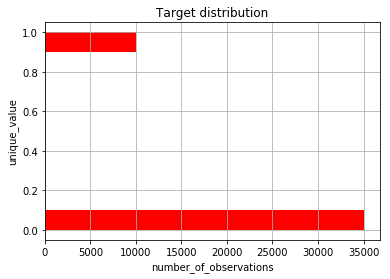

In [4]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target:')
data['SeriousDlqin2yrs'].value_counts() / data.shape[0]

In [5]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [6]:
table = impute_nan_with_median(data)

In [7]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

In [8]:
!pip install watermark
%load_ext watermark

In [9]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn -g

CPython 3.6.2
IPython 6.1.0

numpy 1.13.1
scipy 0.19.1
pandas 0.20.3
matplotlib 2.0.2
sklearn 0.19.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.8.0-59-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   :


# 2

In [10]:
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [11]:
data.columns.values

array(['SeriousDlqin2yrs', 'age', 'NumberOfTime30-59DaysPastDueNotWorse',
       'DebtRatio', 'NumberOfTimes90DaysLate',
       'NumberOfTime60-89DaysPastDueNotWorse', 'MonthlyIncome',
       'NumberOfDependents'], dtype=object)

In [12]:
bad = (data['SeriousDlqin2yrs'] == True)

In [13]:
real_bad = (data['SeriousDlqin2yrs'] == True) | (data['NumberOfTime30-59DaysPastDueNotWorse'] > 0) \
| (data['NumberOfTimes90DaysLate'] > 0) | (data['NumberOfTime60-89DaysPastDueNotWorse'] > 0)

In [14]:
def get_difference(data, column, mask, accuracy):
    
    bad_doges = data[mask][column].values
    good_doges = data[~mask][column].values

    np.random.seed(17)

    good_mean_scores = [np.mean(sample) 
                           for sample in get_bootstrap_samples(good_doges, 500)]
    bad_mean_scores = [np.mean(sample) 
                           for sample in get_bootstrap_samples(bad_doges, 500)]

    a,b = stat_intervals(good_mean_scores, 1.0-accuracy)
    c,d = stat_intervals(bad_mean_scores, 1.0-accuracy)
    print("Good:\t{} - {}".format(a,b))
    print("Bad:\t{} - {}".format(c,d))
    print(round(a-d))

In [15]:
get_difference(data, 'MonthlyIncome', bad, 0.9)

Good:	6300.800252590119 - 6503.7705611211
Bad:	5464.351875124676 - 5646.002129463395
655.0


In [16]:
get_difference(data, 'MonthlyIncome', real_bad, 0.9)

Good:	6281.347528301886 - 6540.403085763293
Bad:	5771.4058254257525 - 5985.509275435179
296.0


# 3

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

dt = DecisionTreeClassifier(random_state=17, class_weight='balanced')

In [18]:
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

In [19]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [20]:
gcv = GridSearchCV(dt, tree_params, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5, 6, 7, 8, 9], 'max_features': [4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [21]:
gcv.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [22]:
gcv.best_params_

{'max_depth': 5, 'max_features': 7}

In [23]:
gcv.best_score_

0.81394935978518967

In [24]:
np.mean(gcv.cv_results_['std_test_score']) < 0.01

True

# 4

In [42]:
from sklearn.model_selection import cross_val_score

from sklearn.base import BaseEstimator

class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=5, max_features=7, random_state=17):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        # в данном списке будем хранить отдельные деревья
        self.trees = []
        # тут будем хранить списки индексов признаков, на которых обучалось каждое дерево 
        self.feat_ids_by_tree = []
        self.preds = []
        
    def get_bootstrap_samples(self, X, y, n_samples=10):
        # функция для генерации подвыборок с помощью бутстрэпа
        indices = np.random.randint(0, len(y), (n_samples, len(y)))
        self.feat_ids_by_tree = indices
        values = X.values[indices]
        labels = y.values[indices]
        return values, labels
        
    def fit(self, X, y):
        X,y = self.get_bootstrap_samples(X,y)
        for i in range(0,self.n_estimators):
            #print('tree {}/{}'.format(i, self.n_estimators))
            rs = self.random_state + i
            dt = DecisionTreeClassifier(random_state=rs, class_weight='balanced', max_features=self.max_features,
                                       max_depth=self.max_depth)
            dt.fit(X[i],y[i])
            self.trees.append(dt)
            #self.preds.append(roc_auc_score([round(x[1]-0.4) for x in dt.predict_proba(X[i])],y[i]))
        #print('Done fitting')
        return self
    
    def predict_proba(self, X):
        res = 0
        for tree in self.trees:
            res+=(tree.predict_proba(X.values))
        return res/len(self.feat_ids_by_tree)

In [43]:
test = RandomForestClassifierCustom()

In [44]:
test.fit(X, y)

RandomForestClassifierCustom(max_depth=5, max_features=7, n_estimators=10,
               random_state=17)

In [45]:
cross_val_score(estimator=test,X=X, y=y,scoring='roc_auc').mean()

0.82214663775051944

# 5

In [46]:
from sklearn.ensemble import RandomForestClassifier
score = cross_val_score(RandomForestClassifier(n_jobs=1, random_state=17, max_depth=5, max_features=7, n_estimators=10),
                X,y,cv=5).mean()

In [47]:
def closer(a,b,c):
    d1 = abs(a-b)
    d2 = abs(a-c)
    if d1>d2:
        return c
    else:
        return b

In [48]:
closer(score, 0.833, 0.843)

0.843

# 6

In [49]:
max_depth_values = range(5, 16)
max_features_values = range(4, 8)
forest_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}



In [52]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
gcv = GridSearchCV(test, forest_params, n_jobs=-1, verbose=1, scoring='roc_auc', cv=skf)
gcv.fit(X, y)

Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:   37.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifierCustom(max_depth=5, max_features=7, n_estimators=10,
               random_state=17),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(5, 16), 'max_features': range(4, 8)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [53]:
gcv.best_params_

{'max_depth': 8, 'max_features': 4}

# 7

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
logit = LogisticRegression(random_state=17, class_weight='balanced')

logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])
logit_pipe_params = {'logit__C': np.logspace(-8, 8, 17)}

In [59]:
grid_search = GridSearchCV(logit_pipe, logit_pipe_params, n_jobs=-1, verbose=1, scoring='roc_auc', cv=skf)

In [60]:
grid_search.fit(X,y)

Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    7.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'logit__C': array([  1.00000e-08,   1.00000e-07,   1.00000e-06,   1.00000e-05,
         1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01,   1.00000e+02,   1.00000e+03,
         1.00000e+04,   1.00000e+05,   1.00000e+06,   1.00000e+07,
         1.00000e+08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [61]:
grid_search.best_params_

{'logit__C': 100000.0}

In [62]:
grid_search.best_score_

0.78786267573072055

# 8

In [63]:
# Загрузим данные
df = pd.read_csv("~/Downloads/movie_reviews_train.csv", nrows=50000)

# Разделим данные на текст и целевой признак
X_text = df["text"]
y_text = df["label"]

# Соотношения классов
df.label.value_counts()

1    32492
0    17508
Name: label, dtype: int64

In [68]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# будем разбивать на 3 фолда
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

vectorizer = CountVectorizer(max_features = 100000, ngram_range = (1, 3))
clf = LogisticRegression(random_state=17, class_weight='balanced')

classifier = Pipeline([('vectorizer', vectorizer), ('clf', clf)])


In [69]:
classifier_params = {'clf__C':[0.1, 1, 10, 100]}

In [70]:
grid_search = GridSearchCV(classifier, classifier_params, n_jobs=-1, verbose=1, scoring='roc_auc', cv=skf)

In [71]:
grid_search.fit(X_text, y_text)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   57.7s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   58.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
     ...alty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__C': [0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=1)

In [72]:
grid_search.best_score_

0.8584070834893115

In [73]:
grid_search.best_params_

{'clf__C': 1}

# 9

In [79]:
clf = RandomForestClassifier(random_state=17, n_jobs=-1)

classifier = Pipeline([('vectorizer', vectorizer), ('clf', clf)])

classifier_params = {'clf__min_samples_leaf' : [1, 2, 3],
'clf__max_features' : [0.3, 0.5, 0.7],
'clf__max_depth' : [None]}

In [80]:
clf.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [81]:
grid_search = GridSearchCV(classifier, classifier_params, n_jobs=-1, verbose=1, scoring='roc_auc', cv=skf)

In [82]:
grid_search.fit(X_text, y_text)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 20.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
     ...timators=10, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__min_samples_leaf': [1, 2, 3], 'clf__max_features': [0.3, 0.5, 0.7], 'clf__max_depth': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [83]:
grid_search.best_score_

0.74727464315145131

In [84]:
grid_search.best_params_

{'clf__max_depth': None, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 1}